In [1]:
#chamada 
#if __name__ == '__main__':
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import itertools    


from sklearn import model_selection
from keras.optimizers import SGD
from keras.optimizers import Adam
from collections import Counter
#vamos importar as classes para realizar o random RandomOverSampler e SMOTE
from imblearn.over_sampling import RandomOverSampler, SMOTE



from tqdm import tqdm
from keras import metrics
from keras.utils import np_utils
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

2024-07-02 14:50:38.609218: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
#Devido o conjunto de dados ser muito grande, não será possível enviar junto ao arquivo.Link para baixar o conjunto de dados abaixo 
#--> http://205.174.165.80/IOTDataset/CIC_IOT_Dataset2023/

In [2]:
checkpoint_callback_normal = ModelCheckpoint(
    filepath='melhor_modelo3_normal.h5', #caminho para salvar o arquivo do modelo
    monitor='val_loss', #métrica a ser monitorada
    save_best_only=True, #salvar apenas o melhor modelo
    save_weights_only=False, #salvar o nodelo completo incluindo a arquitetura
    mode='min', #salvar o modelo com a menor perda de validação
    verbose=1  # Modo de verbosidade (0 ou 1)
    
)
checkpoint_callback_sampli = ModelCheckpoint(
    filepath='melhor_modelo3_sampli.h5', #caminho para salvar o arquivo do modelo
    monitor='val_loss', #métrica a ser monitorada
    save_best_only=True, #salvar apenas o melhor modelo
    save_weights_only=False, #salvar o nodelo completo incluindo a arquitetura
    mode='min', #salvar o modelo com a menor perda de validação
    verbose=1  # Modo de verbosidade (0 ou 1)
    
)

checkpoint_callback_modelsmote = ModelCheckpoint(
    filepath='melhor_modelo3_smote.h5', #caminho para salvar o arquivo do modelo
    monitor='val_loss', #métrica a ser monitorada
    save_best_only=True, #salvar apenas o melhor modelo
    save_weights_only=False, #salvar o nodelo completo incluindo a arquitetura
    mode='min', #salvar o modelo com a menor perda de validação
    verbose=1  # Modo de verbosidade (0 ou 1)
    
)

callback_stop_patience = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

#função de callbackt
class Mycallback(tf.keras.callbacks.Callback):
    def on_epochs_end(self, epoch, logs={}):
        if logs.get('accuracy') > 1.0:
            print('accuracy: 100%, vamos cancelar o treino! Essa condição já nos satisfaz!')
            self.model.stop_training = True
            

In [3]:
#vamos definir as métricas de avaliação
metricas = [
    metrics.FalseNegatives(name="fn"),
    metrics.FalsePositives(name="fp"),
    metrics.TrueNegatives(name="Tn"),
    metrics.TruePositives(name="Tp"),
    metrics.Precision(name="precision"),
    metrics.Recall(name="recall"),
    
]

2024-07-02 14:50:44.622127: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
dict_7classes = {}
dict_7classes['DDoS-RSTFINFlood'] = 'DDoS'
dict_7classes['DDoS-PSHACK_Flood'] = 'DDoS'
dict_7classes['DDoS-SYN_Flood'] = 'DDoS'
dict_7classes['DDoS-UDP_Flood'] = 'DDoS'
dict_7classes['DDoS-TCP_Flood'] = 'DDoS'
dict_7classes['DDoS-ICMP_Flood'] = 'DDoS'
dict_7classes['DDoS-SynonymousIP_Flood'] = 'DDoS'
dict_7classes['DDoS-ACK_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-UDP_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-ICMP_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-SlowLoris'] = 'DDoS'
dict_7classes['DDoS-HTTP_Flood'] = 'DDoS'

dict_7classes['DoS-UDP_Flood'] = 'DoS'
dict_7classes['DoS-SYN_Flood'] = 'DoS'
dict_7classes['DoS-TCP_Flood'] = 'DoS'
dict_7classes['DoS-HTTP_Flood'] = 'DoS'


dict_7classes['Mirai-greeth_flood'] = 'Mirai'
dict_7classes['Mirai-greip_flood'] = 'Mirai'
dict_7classes['Mirai-udpplain'] = 'Mirai'

dict_7classes['Recon-PingSweep'] = 'Recon'
dict_7classes['Recon-OSScan'] = 'Recon'
dict_7classes['Recon-PortScan'] = 'Recon'
dict_7classes['VulnerabilityScan'] = 'Recon'
dict_7classes['Recon-HostDiscovery'] = 'Recon'

dict_7classes['DNS_Spoofing'] = 'Spoofing'
dict_7classes['MITM-ArpSpoofing'] = 'Spoofing'

dict_7classes['BenignTraffic'] = 'Benign'

dict_7classes['BrowserHijacking'] = 'Web'
dict_7classes['Backdoor_Malware'] = 'Web'
dict_7classes['XSS'] = 'Web'
dict_7classes['Uploading_Attack'] = 'Web'
dict_7classes['SqlInjection'] = 'Web'
dict_7classes['CommandInjection'] = 'Web'


dict_7classes['DictionaryBruteForce'] = 'BruteForce'

In [5]:
def plotagem_dados(y):
    #contagem das classes
    data = Counter(y)
    #adicionando os valores de cada classe em uma lista
    counts = list(data.values())

    #nomes das categorias
    category_names = ['DDoS',
             'DoS',
             'Mirai',
             'Benign',
             'Spoofing',
             'Recon',
             'Web',
             'BruteForce'] 
    #craindo a figura
    plt.figure(figsize=(10,6))

    plt.bar(category_names, counts, color=['red','green','blue'])
    plt.xlabel('Categoria dos Ataques')
    plt.ylabel('Números de Ataques')
    plt.title('Ataques IoT')
    plt.show()

In [6]:
def smote_class(X,y):
    print("Distribuição original:", Counter(y))
    #aplicando a técnica de SMOTE
    smote = SMOTE(random_state=42)
    X_smot, y_smot = smote.fit_resample(X,y)
    print("Distribuição SMOTE:", Counter(y_smot))
    return X_smot, y_smot


def RandomOver_class(X, y):
    print("Distribuição original:", Counter(y))
    ros = RandomOverSampler(random_state=42)
    X_Roversampling, y_roversampling = ros.fit_resample(X,y)
    return X_Roversampling, y_roversampling


In [7]:
def preprocessing():
    DATASET_DIRECTORY = 'CICIoT2023'
    #dataset k.endswith('.csv') -> pega somente os arquivos que terminam com .csv
    data_set = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
    data_set_n = sorted(data_set)
    #pegando os dados de train
    training_sets = data_set_n[:int(len(data_set_n)*0.8)]
    #pegando os dados de test
    test_sets = data_set_n[int(len(data_set_n)*0.8):]


    
    #dados de test
    for test in test_sets:
        path = DATASET_DIRECTORY+'/'+test
        test = pd.read_csv(path)
        new_y_test = [dict_7classes[k] for k in test['label']]
        y_test = new_y_test
        X_test = test.drop('label', axis=1)
        

    for train in training_sets:
        path = DATASET_DIRECTORY+'/'+train
        train = pd.read_csv(path)
        new_y_train = [dict_7classes[k] for k in train['label']]
        y_train = new_y_train
        X_train = train.drop('label', axis=1)



    #plotagem dos dados normais
    plotagem_dados(y_train)
    #igualando os dados com técnica simples
    X_train_sampling, y_train_sampling = RandomOver_class(X_train, y_train)
    plotagem_dados(y_train_sampling)

    #utilizando SMOTE
    X_train_smote, y_train_smote = smote_class(X_train, y_train)
    plotagem_dados(y_train_smote)

    
    #transformar dados de treino
    X_train_normalizador = MinMaxScaler()
    X_train = X_train_normalizador.fit_transform(X_train)
 
    labelencoder_train  = LabelEncoder()
    y_train = labelencoder_train.fit_transform(y_train)
    y_train = np_utils.to_categorical(y_train)

        
    #transformar dados de treino sampling
    X_train_sampling_normalizador = MinMaxScaler()
    X_train_sampling = X_train_sampling_normalizador.fit_transform(X_train_sampling)
    

    labelencoder_train  = LabelEncoder()
    y_train_sampling = labelencoder_train.fit_transform(y_train_sampling)
    y_train_sampling = np_utils.to_categorical(y_train_sampling)

        
    #transformar dados de treino smote
    X_train_smote_normalizador = MinMaxScaler()
    X_train_smote = X_train_smote_normalizador.fit_transform(X_train_smote)
    

    labelencoder_train  = LabelEncoder()
    y_train_smote = labelencoder_train.fit_transform(y_train_smote)
    y_train_smote = np_utils.to_categorical(y_train_smote)
    

    
    #transformar dados de teste entre 0 e 1
    X_test_normalizador = MinMaxScaler()
    X_test = X_test_normalizador.fit_transform(X_test)
    
    #transformar em números inteiros
    labelencoder_teste = LabelEncoder()
    y_test = labelencoder_teste.fit_transform(y_test)
    #transformação em  vetores binários
    y_test = np_utils.to_categorical(y_test)

 


    return X_train, y_train, X_train_sampling, y_train_sampling, X_train_smote, y_train_smote, X_test, y_test

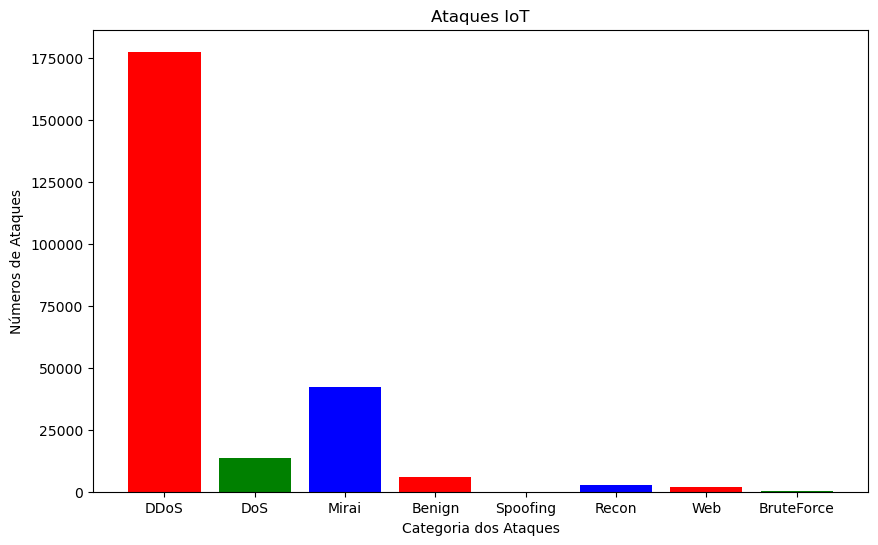

Distribuição original: Counter({'DDoS': 177426, 'DoS': 42363, 'Mirai': 13595, 'Benign': 5738, 'Spoofing': 2532, 'Recon': 1790, 'Web': 136, 'BruteForce': 69})


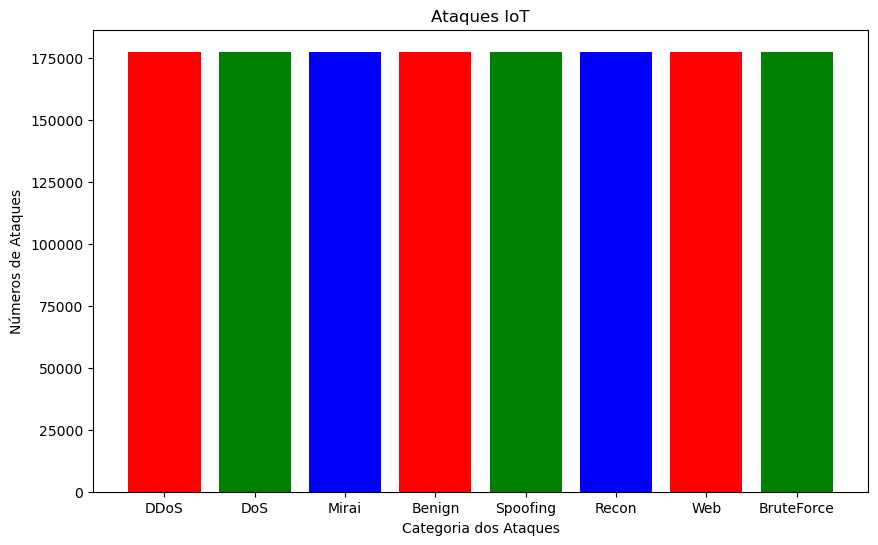

Distribuição original: Counter({'DDoS': 177426, 'DoS': 42363, 'Mirai': 13595, 'Benign': 5738, 'Spoofing': 2532, 'Recon': 1790, 'Web': 136, 'BruteForce': 69})
Distribuição SMOTE: Counter({'DDoS': 177426, 'Mirai': 177426, 'DoS': 177426, 'Benign': 177426, 'BruteForce': 177426, 'Spoofing': 177426, 'Recon': 177426, 'Web': 177426})


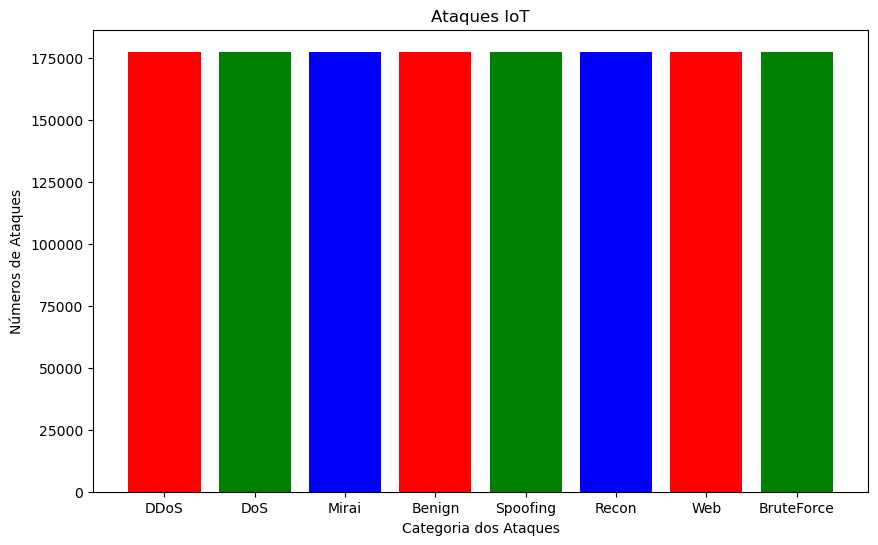

In [8]:
X_train, y_train, X_train_sampling, y_train_sampling, X_train_smote, y_train_smote, X_test, y_test_dump = preprocessing()

In [12]:
#X_train_sampling_nor, y_train_sampling_nor, X_test_normal, y_test_normal 
X_train_samply,X_validation_train_samply, y_train_samply, y_validation_train_samply = model_selection.train_test_split(X_train_sampling, y_train_sampling,
                                                                            test_size=0.2, random_state=1, stratify=y_train_sampling)

In [9]:
X_train, X_validation, y_train, y_validation = model_selection.train_test_split(X_train, y_train,test_size=0.3, random_state=1, stratify=y_train)



In [11]:

X_train_smote, X_validation_smote, y_train_smote, y_validation_smote = model_selection.train_test_split(X_train_smote, y_train_smote,test_size=0.3, random_state=1, stratify=y_train_smote)



In [29]:
def modeloDense2(X_train, metricas):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(500, activation="relu", input_shape=(X_train.shape[-1],)),
        tf.keras.layers.Dense(units=500, activation='relu', kernel_initializer="random_uniform", bias_initializer="random_uniform"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(units=500, activation='relu', kernel_initializer="random_uniform", bias_initializer="random_uniform"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(units=500, activation='relu', kernel_initializer="random_uniform", bias_initializer="random_uniform"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(units=500, activation='relu', kernel_initializer="random_uniform", bias_initializer="random_uniform"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(8,activation='softmax')
        
    ])
    model.compile(loss='categorical_crossentropy',optimizer=Adam(1e-3), metrics=metricas)
    return model

In [21]:
def modeloDenseFinal(X_train, metricas):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(500, activation="relu", input_shape=(X_train.shape[-1],)),
        tf.keras.layers.Dense(units=500, activation='relu', kernel_initializer="random_uniform", bias_initializer="random_uniform"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(units=500, activation='relu', kernel_initializer="random_uniform", bias_initializer="random_uniform"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(units=500, activation='relu', kernel_initializer="random_uniform", bias_initializer="random_uniform"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(units=500, activation='relu', kernel_initializer="random_uniform", bias_initializer="random_uniform"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(units=500, activation='relu', kernel_initializer="random_uniform", bias_initializer="random_uniform"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(units=500, activation='relu', kernel_initializer="random_uniform", bias_initializer="random_uniform"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(units=500, activation='relu', kernel_initializer="random_uniform", bias_initializer="random_uniform"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(8,activation='softmax')
        
    ])
    model.compile(loss='categorical_crossentropy',optimizer=Adam(1e-3), metrics=metricas)
    return model

In [22]:
#X_train, X_validation, y_train, y_validation
model_Densfinal = modeloDenseFinal(X_train,metricas)
model_Densfinal_normal = model_Densfinal.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                  batch_size=300, epochs=200, verbose=1, callbacks=[Mycallback(), checkpoint_callback_normal, callback_stop_patience])

Epoch 1/200
568/569 [============================>.] - ETA: 0s - loss: 0.4523 - fn: 50670.0000 - fp: 40473.0000 - Tn: 1663992.0000 - Tp: 192825.0000 - precision: 0.8265 - recall: 0.7919
Epoch 1: val_loss did not improve from 0.33369
569/569 [==============================] - 31s 54ms/step - loss: 0.4522 - fn: 50693.0000 - fp: 40494.0000 - Tn: 1665049.0000 - Tp: 192956.0000 - precision: 0.8265 - recall: 0.7919 - val_loss: 0.3590 - val_fn: 12949.0000 - val_fp: 12414.0000 - val_Tn: 499251.0000 - val_Tp: 60146.0000 - val_precision: 0.8289 - val_recall: 0.8228
Epoch 2/200
568/569 [============================>.] - ETA: 0s - loss: 0.3684 - fn: 31071.0000 - fp: 28453.0000 - Tn: 1164347.0000 - Tp: 139329.0000 - precision: 0.8304 - recall: 0.8177
Epoch 2: val_loss did not improve from 0.33369
569/569 [==============================] - 29s 51ms/step - loss: 0.3684 - fn: 31095.0000 - fp: 28476.0000 - Tn: 1165402.0000 - Tp: 139459.0000 - precision: 0.8304 - recall: 0.8177 - val_loss: 0.3550 - val_

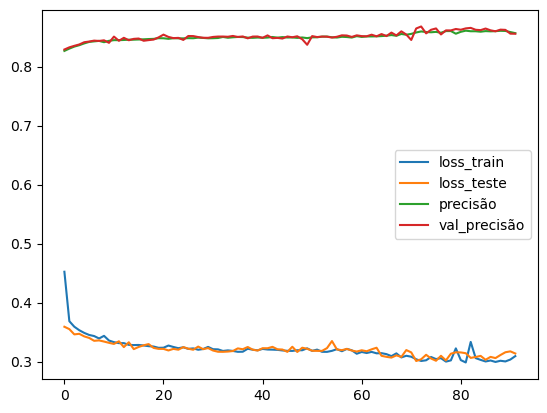

In [23]:
plt.plot(model_Densfinal_normal.history["loss"], label="loss_train")
plt.plot(model_Densfinal_normal.history["val_loss"], label="loss_teste")
plt.plot(model_Densfinal_normal.history["precision"], label="precisão")
plt.plot(model_Densfinal_normal.history["val_precision"], label="val_precisão")
#plt.plot(history.history["tp"], label="tp")
#plt.plot(history.history["val_tp"], label="val_tp")
plt.legend()

In [24]:
TrainPredictions = model_Densfinal.predict(X_test)
#convertendo dados onehot encoder para rotulos de classes
TrainPredictions_convert = np.argmax(TrainPredictions, axis=1)
y_train_rotulos = np.argmax(y_test_dump, axis=1)

7336/7336 [==============================] - 36s 5ms/step


Text(0.5, 23.52222222222222, 'Predicted label')

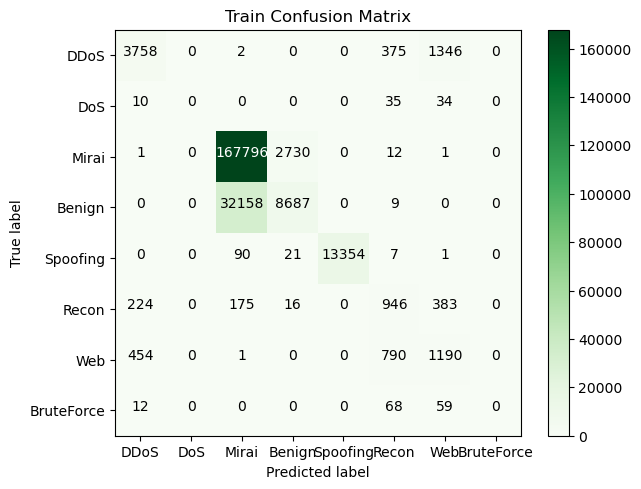

In [19]:
conf = confusion_matrix(y_train_rotulos, TrainPredictions_convert)

classes = ['DDoS', 'DoS','Mirai','Benign','Spoofing','Recon','Web','BruteForce']
#classes = [0,1,2,3,4,5,6,7]
#plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Train Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [20]:
print('Confusion Matrix\n')
print(conf)
#Micro: Foca no total agregado de verdadeiros positivos, falsos negativos e falsos positivos. Cada instância conta igualmente.
#importar as métricas 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(f'Accuracy: {accuracy_score(y_train_rotulos,TrainPredictions_convert)}\n')
print(f"Micro Precision: {precision_score(y_train_rotulos,TrainPredictions_convert, average='micro')}\n")
print(f"Micro Recall: {recall_score(y_train_rotulos,TrainPredictions_convert, average='micro')}\n")
print(f'Micro F1_score: {f1_score(y_train_rotulos,TrainPredictions_convert, average="micro")}\n')

#Macro: Calcula a métrica para cada classe individualmente e tira a média aritmética. Cada classe conta igualmente.
print(f'Macro Precision: {precision_score(y_train_rotulos,TrainPredictions_convert, average="macro")}\n')
print(f'Macro Recall: {recall_score(y_train_rotulos,TrainPredictions_convert, average="macro")}\n')
print(f'Macro F1_score: {f1_score(y_train_rotulos,TrainPredictions_convert, average="macro")}\n')

#Weighted: Calcula a métrica para cada classe individualmente e tira a média ponderada pelo número de instâncias em cada classe. Considera o desequilíbrio de classes.
print(f'Weighted Precision: {precision_score(y_train_rotulos,TrainPredictions_convert, average="weighted")}\n')
print(f'Weighted Recall: {recall_score(y_train_rotulos,TrainPredictions_convert, average="weighted")}\n')
print(f'Weighted F1_score: {f1_score(y_train_rotulos,TrainPredictions_convert, average="weighted")}\n')

#me tráz métricas de avaliação para modelos multiclasses
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_train_rotulos, TrainPredictions_convert,target_names= ['DDoS', 'DoS','Mirai','Benign','Spoofing','Recon','Web','BruteForce']))
#target_names= ['DDoS', 'DoS','Mirai','Benign','Spoofing','Recon','Web','BruteForce']
#target_names= ['0', '1','2','3','4','5','6','7']

Confusion Matrix

[[  3758      0      2      0      0    375   1346      0]
 [    10      0      0      0      0     35     34      0]
 [     1      0 167796   2730      0     12      1      0]
 [     0      0  32158   8687      0      9      0      0]
 [     0      0     90     21  13354      7      1      0]
 [   224      0    175     16      0    946    383      0]
 [   454      0      1      0      0    790   1190      0]
 [    12      0      0      0      0     68     59      0]]
Accuracy: 0.8338026369038745

Micro Precision: 0.8338026369038745

Micro Recall: 0.8338026369038745

Micro F1_score: 0.8338026369038745

Macro Precision: 0.5320041848139678



/home/aluno/anaconda3/envs/aluno/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aluno/anaconda3/envs/aluno/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro Recall: 0.4880614444436708

Macro F1_score: 0.48755363075904745

Weighted Precision: 0.82513068056409

Weighted Recall: 0.8338026369038745

Weighted F1_score: 0.7982336512140473


Classification Report

              precision    recall  f1-score   support

        DDoS       0.84      0.69      0.76      5481
         DoS       0.00      0.00      0.00        79
       Mirai       0.84      0.98      0.91    170540
      Benign       0.76      0.21      0.33     40854
    Spoofing       1.00      0.99      1.00     13473
       Recon       0.42      0.54      0.47      1744
         Web       0.39      0.49      0.44      2435
  BruteForce       0.00      0.00      0.00       139

    accuracy                           0.83    234745
   macro avg       0.53      0.49      0.49    234745
weighted avg       0.83      0.83      0.80    234745



/home/aluno/anaconda3/envs/aluno/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aluno/anaconda3/envs/aluno/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aluno/anaconda3/envs/aluno/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [18]:
#X_train_samply,X_validation_train_samply, y_train_samply, y_validation_train_samply
model_Densfinal_samply = modeloDenseFinal(X_train_samply,metricas)
model_Dense_samply = model_Densfinal_samply.fit(X_train_samply, y_train_samply, validation_data=(X_validation_train_samply, y_validation_train_samply),
                  batch_size=300, epochs=200, verbose=1, callbacks=[Mycallback(), checkpoint_callback_sampli, callback_stop_patience])

Epoch 1/200
3785/3786 [============================>.] - ETA: 0s - loss: 0.5958 - fn: 366920.0000 - fp: 169569.0000 - Tn: 8290596.0000 - Tp: 841675.0000 - precision: 0.8323 - recall: 0.6964
Epoch 1: val_loss improved from inf to 0.38324, saving model to melhor_modelo3_sampli.h5
3786/3786 [==============================] - 180s 47ms/step - loss: 0.5958 - fn: 366928.0000 - fp: 169576.0000 - Tn: 8290771.0000 - Tp: 841693.0000 - precision: 0.8323 - recall: 0.6964 - val_loss: 0.3832 - val_fn: 56082.0000 - val_fp: 33216.0000 - val_Tn: 1953958.0000 - val_Tp: 227800.0000 - val_precision: 0.8727 - val_recall: 0.8024
Epoch 2/200
3786/3786 [==============================] - ETA: 0s - loss: 0.3601 - fn: 201402.0000 - fp: 139648.0000 - Tn: 7809034.0000 - Tp: 934124.0000 - precision: 0.8699 - recall: 0.8226
Epoch 2: val_loss improved from 0.38324 to 0.28761, saving model to melhor_modelo3_sampli.h5
3786/3786 [==============================] - 175s 46ms/step - loss: 0.3601 - fn: 201402.0000 - fp: 139

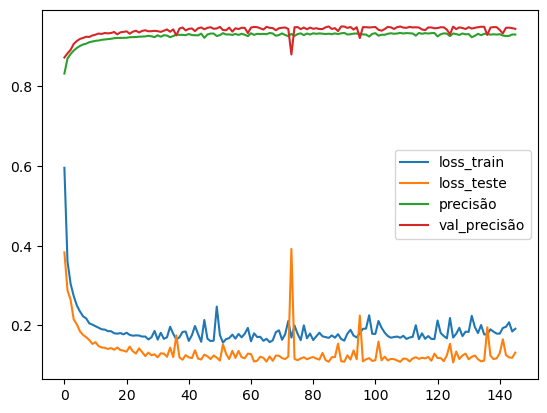

In [28]:
plt.plot(model_Dense_samply.history["loss"], label="loss_train")
plt.plot(model_Dense_samply.history["val_loss"], label="loss_teste")
plt.plot(model_Dense_samply.history["precision"], label="precisão")
plt.plot(model_Dense_samply.history["val_precision"], label="val_precisão")
#plt.plot(history.history["tp"], label="tp")
#plt.plot(history.history["val_tp"], label="val_tp")
plt.legend()

In [32]:
TrainPredictions = model_Densfinal_samply.predict(X_test)
#convertendo dados onehot encoder para rotulos de classes
TrainPredictions_convert = np.argmax(TrainPredictions, axis=1)
y_train_rotulos = np.argmax(y_test_dump, axis=1)

7336/7336 [==============================] - 22s 3ms/step


Text(0.5, 23.52222222222222, 'Predicted label')

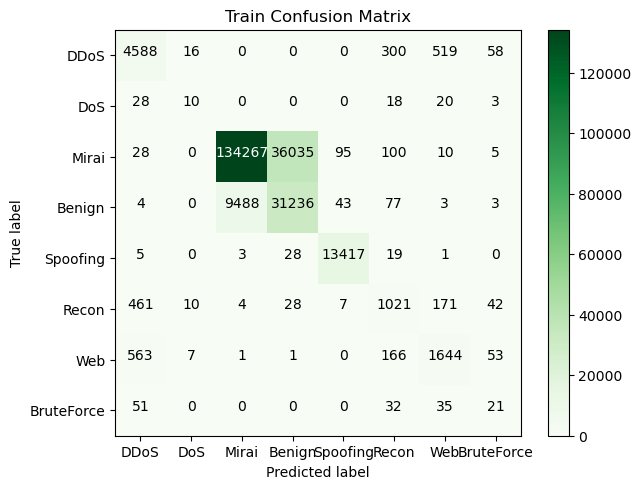

In [33]:
conf = confusion_matrix(y_train_rotulos, TrainPredictions_convert)

classes = ['DDoS', 'DoS','Mirai','Benign','Spoofing','Recon','Web','BruteForce']
#classes = [0,1,2,3,4,5,6,7]
#plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Train Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [34]:
print('Confusion Matrix\n')
print(conf)
#Micro: Foca no total agregado de verdadeiros positivos, falsos negativos e falsos positivos. Cada instância conta igualmente.
#importar as métricas 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(f'Accuracy: {accuracy_score(y_train_rotulos,TrainPredictions_convert)}\n')
print(f"Micro Precision: {precision_score(y_train_rotulos,TrainPredictions_convert, average='micro')}\n")
print(f"Micro Recall: {recall_score(y_train_rotulos,TrainPredictions_convert, average='micro')}\n")
print(f'Micro F1_score: {f1_score(y_train_rotulos,TrainPredictions_convert, average="micro")}\n')

#Macro: Calcula a métrica para cada classe individualmente e tira a média aritmética. Cada classe conta igualmente.
print(f'Macro Precision: {precision_score(y_train_rotulos,TrainPredictions_convert, average="macro")}\n')
print(f'Macro Recall: {recall_score(y_train_rotulos,TrainPredictions_convert, average="macro")}\n')
print(f'Macro F1_score: {f1_score(y_train_rotulos,TrainPredictions_convert, average="macro")}\n')

#Weighted: Calcula a métrica para cada classe individualmente e tira a média ponderada pelo número de instâncias em cada classe. Considera o desequilíbrio de classes.
print(f'Weighted Precision: {precision_score(y_train_rotulos,TrainPredictions_convert, average="weighted")}\n')
print(f'Weighted Recall: {recall_score(y_train_rotulos,TrainPredictions_convert, average="weighted")}\n')
print(f'Weighted F1_score: {f1_score(y_train_rotulos,TrainPredictions_convert, average="weighted")}\n')

#me tráz métricas de avaliação para modelos multiclasses
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_train_rotulos, TrainPredictions_convert,target_names= ['DDoS', 'DoS','Mirai','Benign','Spoofing','Recon','Web','BruteForce']))
#target_names= ['DDoS', 'DoS','Mirai','Benign','Spoofing','Recon','Web','BruteForce']
#target_names= ['0', '1','2','3','4','5','6','7']

Confusion Matrix

[[  4588     16      0      0      0    300    519     58]
 [    28     10      0      0      0     18     20      3]
 [    28      0 134267  36035     95    100     10      5]
 [     4      0   9488  31236     43     77      3      3]
 [     5      0      3     28  13417     19      1      0]
 [   461     10      4     28      7   1021    171     42]
 [   563      7      1      1      0    166   1644     53]
 [    51      0      0      0      0     32     35     21]]
Accuracy: 0.7932181729110311

Micro Precision: 0.7932181729110311

Micro Recall: 0.7932181729110311

Micro F1_score: 0.7932181729110311

Macro Precision: 0.6009423534898843

Macro Recall: 0.6153811989887291

Macro F1_score: 0.6004394222478875

Weighted Precision: 0.8463466348626126

Weighted Recall: 0.7932181729110311

Weighted F1_score: 0.8088252115997443


Classification Report

              precision    recall  f1-score   support

        DDoS       0.80      0.84      0.82      5481
         DoS    

In [12]:
#X_train_smote, X_validation_smote, y_train_smote, y_validation_smote
model_Densfinal_smote = modeloDenseFinal(X_train_smote,metricas)
model_Dense_smote = model_Densfinal_smote.fit(X_train_smote, y_train_smote, validation_data=(X_validation_smote, y_validation_smote),
                batch_size=300, epochs=200, verbose=1, callbacks=[Mycallback(), checkpoint_callback_modelsmote, callback_stop_patience])

Epoch 1/200
3312/3312 [==============================] - ETA: 0s - loss: 0.6098 - fn: 310102.0000 - fp: 144244.0000 - Tn: 6810851.0000 - Tp: 683483.0000 - precision: 0.8257 - recall: 0.6879
Epoch 1: val_loss improved from inf to 0.41322, saving model to melhor_modelo3_smote.h5
3312/3312 [==============================] - 155s 47ms/step - loss: 0.6098 - fn: 310102.0000 - fp: 144244.0000 - Tn: 6810851.0000 - Tp: 683483.0000 - precision: 0.8257 - recall: 0.6879 - val_loss: 0.4132 - val_fn: 85090.0000 - val_fp: 54839.0000 - val_Tn: 2925922.0000 - val_Tp: 340733.0000 - val_precision: 0.8614 - val_recall: 0.8002
Epoch 2/200
3311/3312 [============================>.] - ETA: 0s - loss: 0.3873 - fn: 183742.0000 - fp: 128156.0000 - Tn: 6824944.0000 - Tp: 809558.0000 - precision: 0.8633 - recall: 0.8150
Epoch 2: val_loss improved from 0.41322 to 0.31247, saving model to melhor_modelo3_smote.h5
3312/3312 [==============================] - 149s 45ms/step - loss: 0.3873 - fn: 183789.0000 - fp: 12819

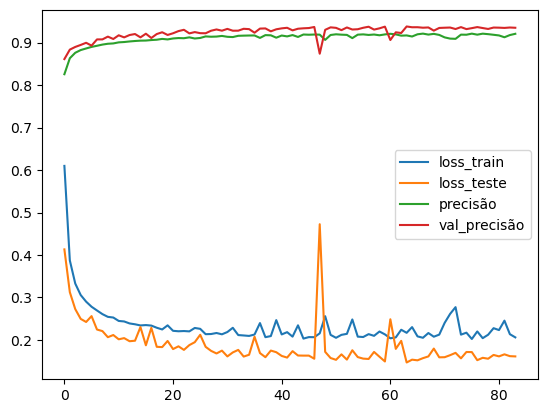

In [13]:
plt.plot(model_Dense_smote.history["loss"], label="loss_train")
plt.plot(model_Dense_smote.history["val_loss"], label="loss_teste")
plt.plot(model_Dense_smote.history["precision"], label="precisão")
plt.plot(model_Dense_smote.history["val_precision"], label="val_precisão")
#plt.plot(history.history["tp"], label="tp")
#plt.plot(history.history["val_tp"], label="val_tp")
plt.legend()

In [14]:
TrainPredictions = model_Densfinal_smote.predict(X_test)
#convertendo dados onehot encoder para rotulos de classes
TrainPredictions_convert = np.argmax(TrainPredictions, axis=1)
y_train_rotulos = np.argmax(y_test_dump, axis=1)

7336/7336 [==============================] - 25s 3ms/step


Text(0.5, 23.52222222222222, 'Predicted label')

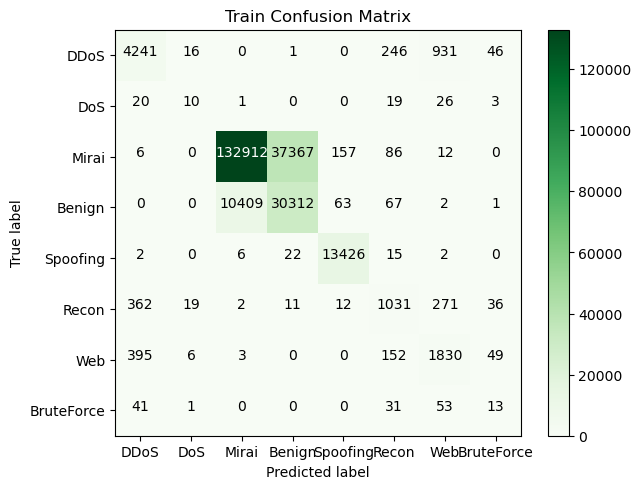

In [15]:
conf = confusion_matrix(y_train_rotulos, TrainPredictions_convert)

classes = ['DDoS', 'DoS','Mirai','Benign','Spoofing','Recon','Web','BruteForce']
#classes = [0,1,2,3,4,5,6,7]
#plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Train Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [16]:
print('Confusion Matrix\n')
print(conf)
#Micro: Foca no total agregado de verdadeiros positivos, falsos negativos e falsos positivos. Cada instância conta igualmente.
#importar as métricas 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(f'Accuracy: {accuracy_score(y_train_rotulos,TrainPredictions_convert)}\n')
print(f"Micro Precision: {precision_score(y_train_rotulos,TrainPredictions_convert, average='micro')}\n")
print(f"Micro Recall: {recall_score(y_train_rotulos,TrainPredictions_convert, average='micro')}\n")
print(f'Micro F1_score: {f1_score(y_train_rotulos,TrainPredictions_convert, average="micro")}\n')

#Macro: Calcula a métrica para cada classe individualmente e tira a média aritmética. Cada classe conta igualmente.
print(f'Macro Precision: {precision_score(y_train_rotulos,TrainPredictions_convert, average="macro")}\n')
print(f'Macro Recall: {recall_score(y_train_rotulos,TrainPredictions_convert, average="macro")}\n')
print(f'Macro F1_score: {f1_score(y_train_rotulos,TrainPredictions_convert, average="macro")}\n')

#Weighted: Calcula a métrica para cada classe individualmente e tira a média ponderada pelo número de instâncias em cada classe. Considera o desequilíbrio de classes.
print(f'Weighted Precision: {precision_score(y_train_rotulos,TrainPredictions_convert, average="weighted")}\n')
print(f'Weighted Recall: {recall_score(y_train_rotulos,TrainPredictions_convert, average="weighted")}\n')
print(f'Weighted F1_score: {f1_score(y_train_rotulos,TrainPredictions_convert, average="weighted")}\n')

#me tráz métricas de avaliação para modelos multiclasses
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_train_rotulos, TrainPredictions_convert,target_names= ['DDoS', 'DoS','Mirai','Benign','Spoofing','Recon','Web','BruteForce']))
#target_names= ['DDoS', 'DoS','Mirai','Benign','Spoofing','Recon','Web','BruteForce']
#target_names= ['0', '1','2','3','4','5','6','7']

Confusion Matrix

[[  4241     16      0      1      0    246    931     46]
 [    20     10      1      0      0     19     26      3]
 [     6      0 132912  37367    157     86     12      0]
 [     0      0  10409  30312     63     67      2      1]
 [     2      0      6     22  13426     15      2      0]
 [   362     19      2     11     12   1031    271     36]
 [   395      6      3      0      0    152   1830     49]
 [    41      1      0      0      0     31     53     13]]
Accuracy: 0.782870774670387

Micro Precision: 0.782870774670387

Micro Recall: 0.782870774670387

Micro F1_score: 0.782870774670387

Macro Precision: 0.5857881130854843

Macro Recall: 0.6068014412712484

Macro F1_score: 0.5885685675595468

Weighted Precision: 0.8383785801108642

Weighted Recall: 0.782870774670387

Weighted F1_score: 0.7994859718261382


Classification Report

              precision    recall  f1-score   support

        DDoS       0.84      0.77      0.80      5481
         DoS       0.